In this chapter, we will introduce your first truly deep network. The simplest deep networks are called multilayer perceptrons, and they consist of multiple layers of neurons each fully connected to those in the layer below (from which they receive input) and those above (which they, in turn, influence). When we train high-capacity models we run the risk of overfitting. Thus, we will need to provide your first rigorous introduction to the notions of overfitting, underfitting, and model selection. To help you combat these problems, we will introduce regularization techniques such as weight decay and dropout. We will also discuss issues relating to numerical stability and parameter initialization that are key to successfully training deep networks.

# Incorporating Hidden Layers
We can overcome these limitations of linear models and handle a more general class of functions by incorporating one or more hidden layers. The easiest way to do this is to stack many fully-connected layers on top of each other. Each layer feeds into the layer above it, until we generate outputs. We can think of the first L-1 layers as our representation and the final layer as our linear predictor. This architecture is commonly called a multilayer perceptron, often abbreviated as MLP.

# Universal Approximators
MLPs can capture complex interactions among our inputs via their hidden neurons, which depend on the values of each of the inputs. We can easily design hidden nodes to perform arbitrary computation, for instance, basic logic operations on a pair of inputs. Moreover, for certain choices of the activation function, it is widely known that MLPs are universal approximators. Even with a single-hidden-layer network, given enough nodes (possibly absurdly many), and the right set of weights, we can model any function, though actually learning that function is the hard part. You might think of your neural network as being a bit like the C programming language. The language, like any other modern language, is capable of expressing any computable program. But actually coming up with a program that meets your specifications is the hard part.

# Activation Function
Activation functions decide whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. They are differentiable operators to transform input signals to outputs, while most of them add non-linearity. Because activation functions are fundamental to deep learning, let us briefly survey some common activation functions.

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

# Relu Function
The most popular choice, due to both simplicity of implementation and its good performance on a variety of predictive tasks, is the rectified linear unit (ReLU). ReLU provides a very simple nonlinear transformation. Informally, the ReLU function retains only positive elements and discards all negative elements by setting the corresponding activations to 0. To gain some intuition, we can plot the function. As you can see, the activation function is piecewise linear.

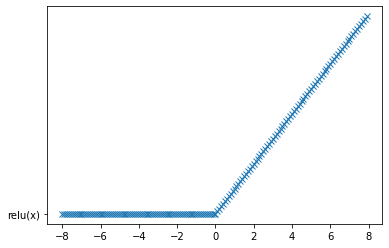

In [2]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1), dtype=tf.float32)
y = tf.nn.relu(x)
plt.plot(x.numpy(), y.numpy(), 'x', 'relu(x)')

When the input is negative, the derivative of the ReLU function is 0, and when the input is positive, the derivative of the ReLU function is 1. Note that the ReLU function is not differentiable when the input takes value precisely equal to 0. In these cases, we default to the left-hand-side derivative and say that the derivative is 0 when the input is 0. We can get away with this because the input may never actually be zero.

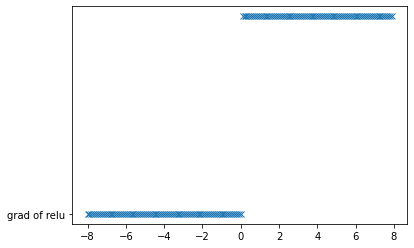

In [3]:
# We plot the derivative of the ReLU function plotted below.
with tf.GradientTape() as t:
    y = tf.nn.relu(x)
plt.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of relu')

Note that there are many variants to the ReLU function, including the parameterized ReLU (pReLU) function. This variation adds a linear term to ReLU, so some information still gets through, even when the argument is negative

# Sigmoid Function
The sigmoid function transforms its inputs, for which values lie in the domain , to outputs that lie on the interval (0, 1). For that reason, the sigmoid is often called a squashing function: it squashes any input in the range (-inf, inf) to some value in the range (0, 1). Sigmoids are still widely used as activation functions on the output units, when we want to interpret the outputs as probabilities for binary classification problems (you can think of the sigmoid as a special case of the softmax). However, the sigmoid has mostly been replaced by the simpler and more easily trainable ReLU for most use in hidden layers.

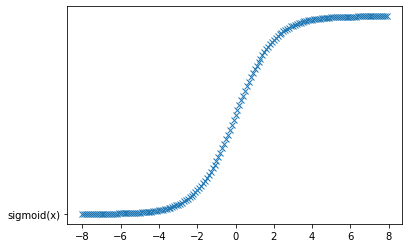

In [4]:
# Below, we plot the sigmoid function. Note that when the input is close to 0, the sigmoid function approaches a linear transformation.
y = tf.nn.sigmoid(x)
plt.plot(x.numpy(), y.numpy(), 'x', 'sigmoid(x)')

' The derivative of the sigmoid function is plotted below. Note that when the input is 0, the derivative of the sigmoid function reaches a maximum of 0.25. \nAs the input diverges from 0 in either direction, the derivative approaches 0. '

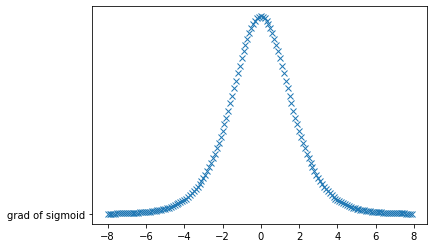

In [5]:
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
plt.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of sigmoid')

""" The derivative of the sigmoid function is plotted below. Note that when the input is 0, the derivative of the sigmoid function reaches a maximum of 0.25. 
As the input diverges from 0 in either direction, the derivative approaches 0. """

# Tanh Function
Like the sigmoid function, the tanh (hyperbolic tangent) function also squashes its inputs, transforming them into elements on the interval between -1 and 1.
We plot the tanh function below. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.

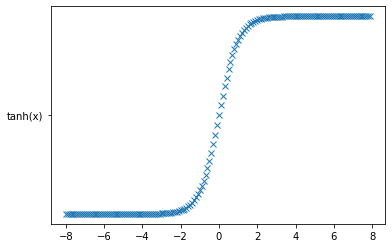

In [6]:
y = tf.nn.tanh(x)
plt.plot(x.numpy(), y.numpy(), 'x', 'tanh(x)')

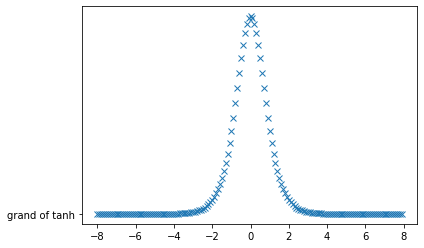

In [7]:
with tf.GradientTape() as t:
    y = tf.nn.tanh(x)
plt.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grand of tanh')

# Forward Propagation, Backward Propagation and Computational Graphs
However, when we implemented the algorithm, we only worried about the calculations involved in forward propagation through the model. When it came time to calculate the gradients, we just invoked the backpropagation function provided by the deep learning framework.

# Forward Propagation
Forward propagation (or forward pass) refers to the calculation and storage of intermediate variables (including outputs) for a neural network in order from the input layer to the output layer. We now work step-by-step through the mechanics of a neural network with one hidden layer

# Backpropagation
Backpropagation refers to the method of calculating the gradient of neural network parameters. In short, the method traverses the network in reverse order, from the output to the input layer, according to the chain rule from calculus. The algorithm stores any intermediate variables (partial derivatives) required while calculating the gradient with respect to some parameters

Therefore when training neural networks, after model parameters are initialized, we alternate forward propagation with backpropagation, updating model parameters using gradients given by backpropagation. Note that backpropagation reuses the stored intermediate values from forward propagation to avoid duplicate calculations. One of the consequences is that we need to retain the intermediate values until backpropagation is complete. This is also one of the reasons why training requires significantly more memory than plain prediction. Besides, the size of such intermediate values is roughly proportional to the number of network layers and the batch size. Thus, training deeper networks using larger batch sizes more easily leads to out of memory errors.

# Vanishing Gradients
One frequent culprit causing the vanishing gradient problem is the choice of the activation function  that is appended following each layer’s linear operations. Historically, the sigmoid function was popular because it resembles a thresholding function. Since early artificial neural networks were inspired by biological neural networks, the idea of neurons that fire either fully or not at all (like biological neurons) seemed appealing. Let us take a closer look at the sigmoid to see why it can cause vanishing gradients.

ValueError: x and y must have same first dimension, but have shapes (160,) and (2, 160)

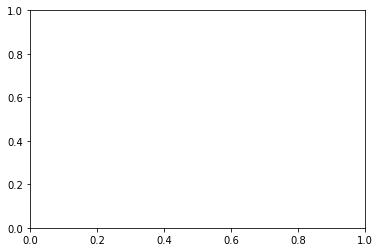

In [9]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

x = tf.Variable(tf.range(-8.0, 8.0, 0.1))
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
plt.plot(x.numpy(), [y.numpy(), t.gradient(y, x).numpy()], legend=['sigmoid', 'gradient'])

As you can see, the sigmoid’s gradient vanishes both when its inputs are large and when they are small. Moreover, when backpropagating through many layers, unless we are in the Goldilocks zone, where the inputs to many of the sigmoids are close to zero, the gradients of the overall product may vanish. When our network boasts many layers, unless we are careful, the gradient will likely be cut off at some layer. Indeed, this problem used to plague deep network training. Consequently, ReLUs, which are more stable (but less neurally plausible), have emerged as the default choice for practitioners.